In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [2]:
# Import necessary libraries
import pandas as pd
from google.colab import files

# Upload the file
uploaded = files.upload()

# Read the CSV file into a dataframe
df = pd.read_csv(list(uploaded.keys())[0])

# Display the first few rows of the dataframe
df.head()


Saving card_transdata.csv.zip to card_transdata.csv.zip


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [ ]:
df.describe()

In [ ]:
df.info()

In [4]:
# Calculate percentages assuming 'fraud' column exists
not_frauds_percent = round(df['fraud'].value_counts()[0] / len(df) * 100, 2)
frauds_percent = round(df['fraud'].value_counts()[1] / len(df) * 100, 2)

# Print percentages
print('Not Frauds:', not_frauds_percent, '% of the dataset')
print('Frauds:', frauds_percent, '% of the dataset')

Not Frauds: 91.26 % of the dataset
Frauds: 8.74 % of the dataset


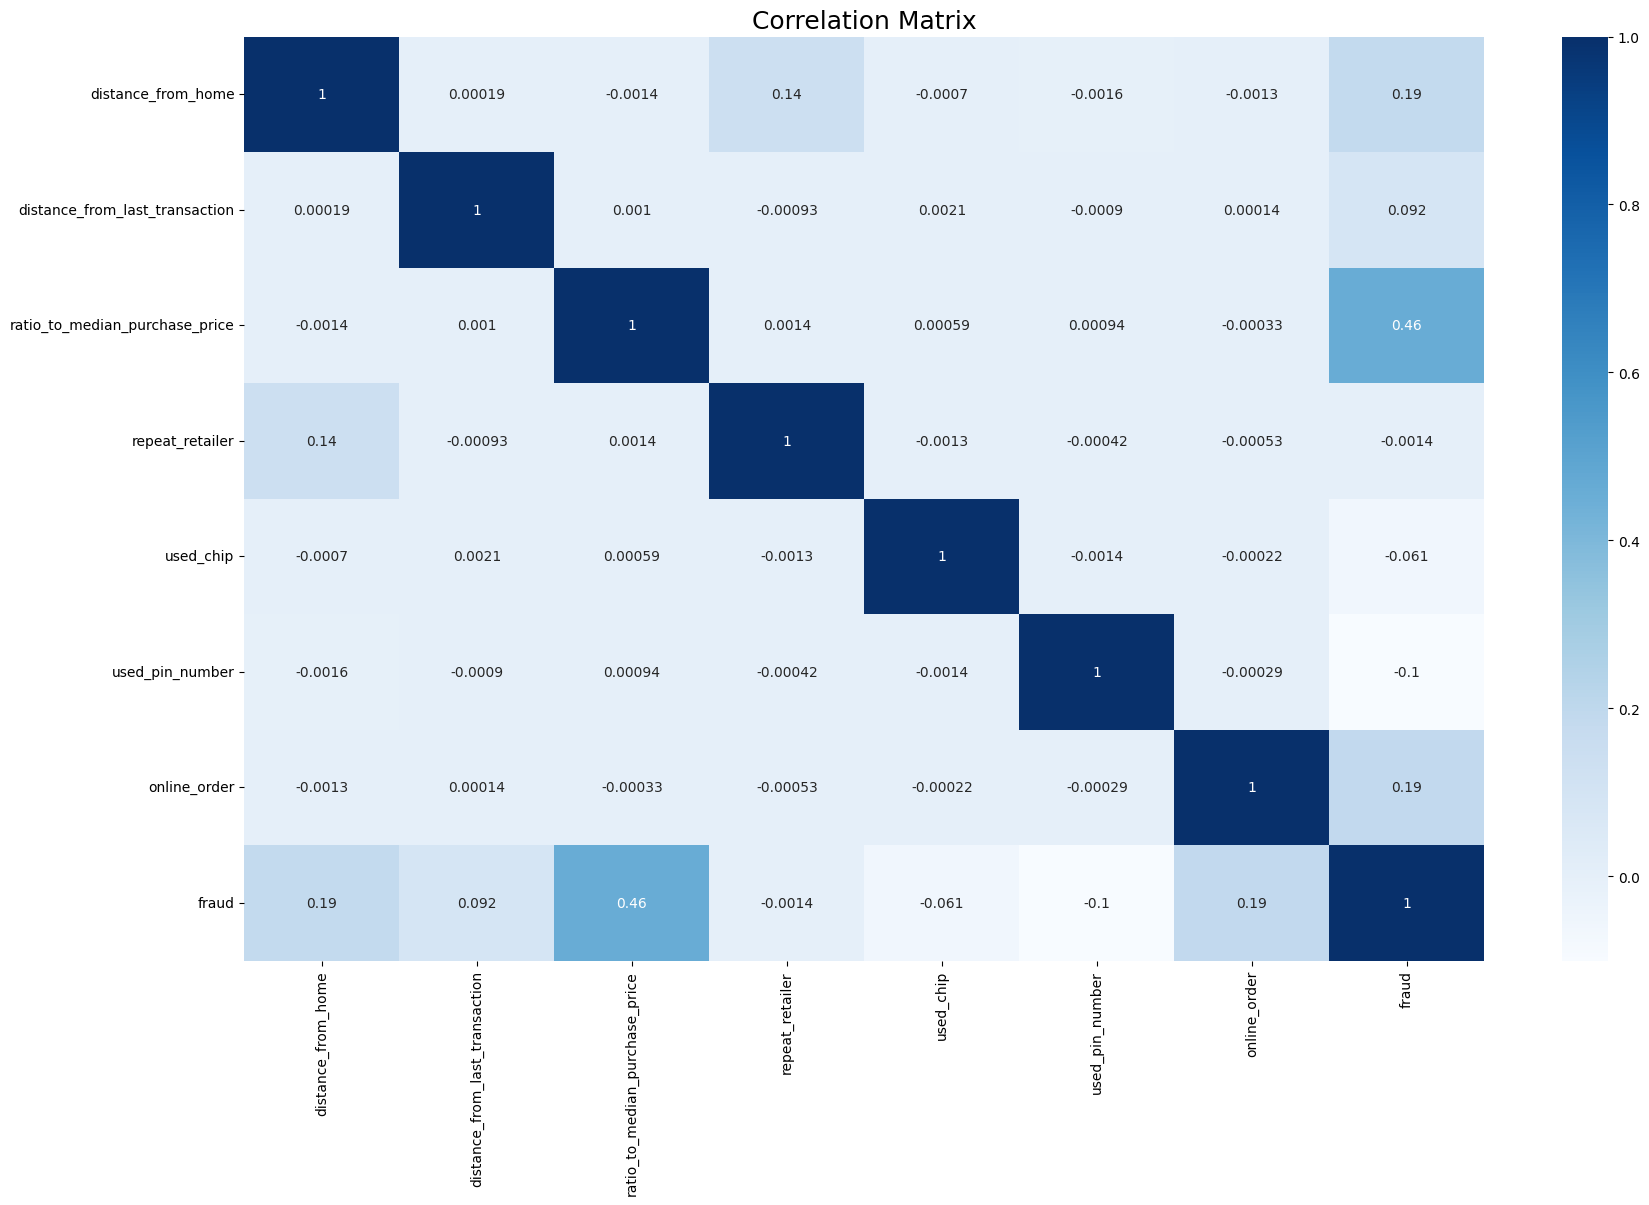

In [6]:
corr = df.corr()

# Set the figure size
plt.figure(figsize=(20, 12))

# Plot heatmap with blue color palette
sns.heatmap(corr, cmap='Blues', xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

# Add title
plt.title('Correlation Matrix', fontsize=18)

# Show plot
plt.show()

<ipython-input-7-485da932d3df>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='Blues')


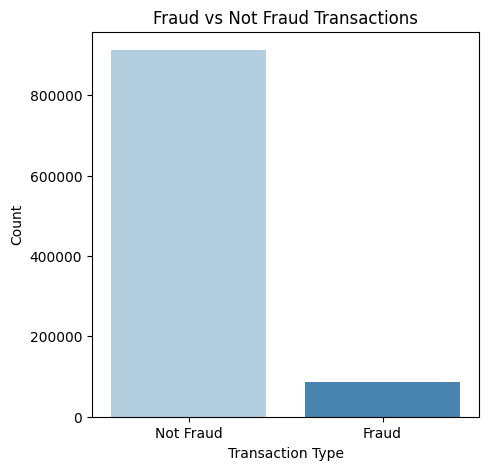

In [7]:
# Calculate fraud counts
fraud_counts = df['fraud'].value_counts()

# Map numeric labels to descriptive labels
fraud_counts.index = fraud_counts.index.map({0: 'Not Fraud', 1: 'Fraud'})

# Plotting a bar chart with elegant shades of blue
plt.figure(figsize=(5, 5))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='Blues')
plt.title('Fraud vs Not Fraud Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

<ipython-input-8-2e5a999072c2>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraud', y='distance_from_home', data=df, palette='Blues')


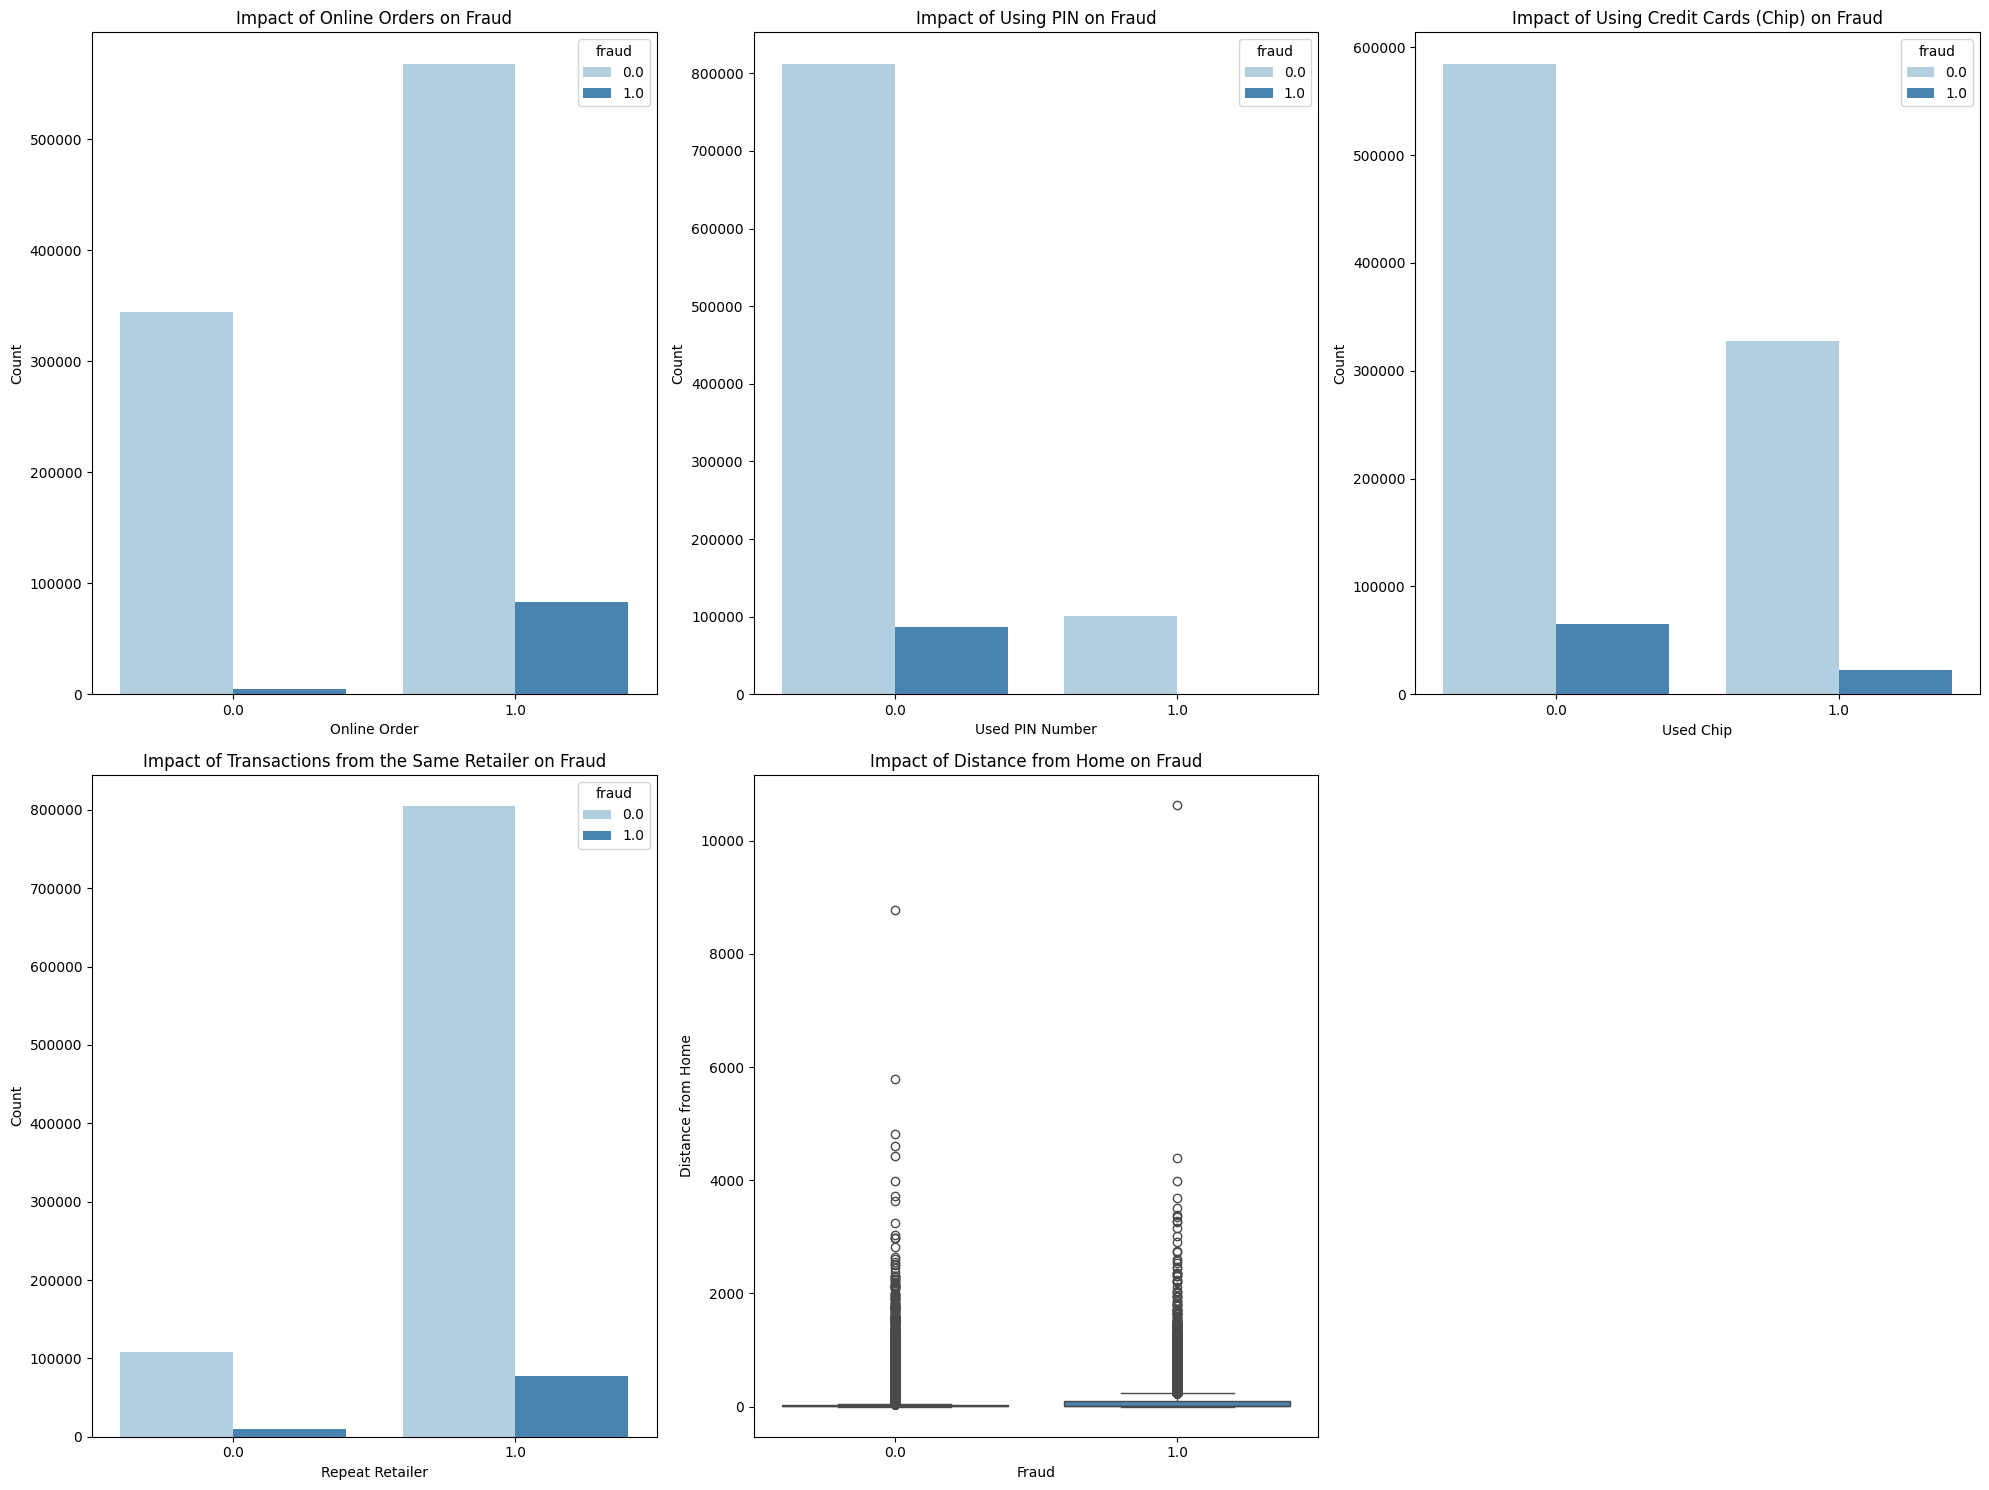

In [8]:
def plot_impact_on_fraud(df):
    plt.figure(figsize=(20, 15))

    # Impact of Online Orders on Fraud
    plt.subplot(2, 3, 1)
    sns.countplot(x='online_order', hue='fraud', data=df, palette='Blues')
    plt.title('Impact of Online Orders on Fraud')
    plt.xlabel('Online Order')
    plt.ylabel('Count')

    # Impact of Using PIN on Fraud
    plt.subplot(2, 3, 2)
    sns.countplot(x='used_pin_number', hue='fraud', data=df, palette='Blues')
    plt.title('Impact of Using PIN on Fraud')
    plt.xlabel('Used PIN Number')
    plt.ylabel('Count')

    # Impact of Using Credit Cards (Chip) on Fraud
    plt.subplot(2, 3, 3)
    sns.countplot(x='used_chip', hue='fraud', data=df, palette='Blues')
    plt.title('Impact of Using Credit Cards (Chip) on Fraud')
    plt.xlabel('Used Chip')
    plt.ylabel('Count')

    # Impact of Transactions from the Same Retailer on Fraud
    plt.subplot(2, 3, 4)
    sns.countplot(x='repeat_retailer', hue='fraud', data=df, palette='Blues')
    plt.title('Impact of Transactions from the Same Retailer on Fraud')
    plt.xlabel('Repeat Retailer')
    plt.ylabel('Count')

    # Impact of Distance from Home on Fraud
    plt.subplot(2, 3, 5)
    sns.boxplot(x='fraud', y='distance_from_home', data=df, palette='Blues')
    plt.title('Impact of Distance from Home on Fraud')
    plt.xlabel('Fraud')
    plt.ylabel('Distance from Home')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_impact_on_fraud(df)

In [9]:
df = df.copy()

# Remove duplicates inplace
df.drop_duplicates(inplace=True)
print("Duplicates removed successfully.")

# Print the count of data after removing duplicates
print("Count of data after removing duplicates:", len(df))

Duplicates removed successfully.
Count of data after removing duplicates: 1000000


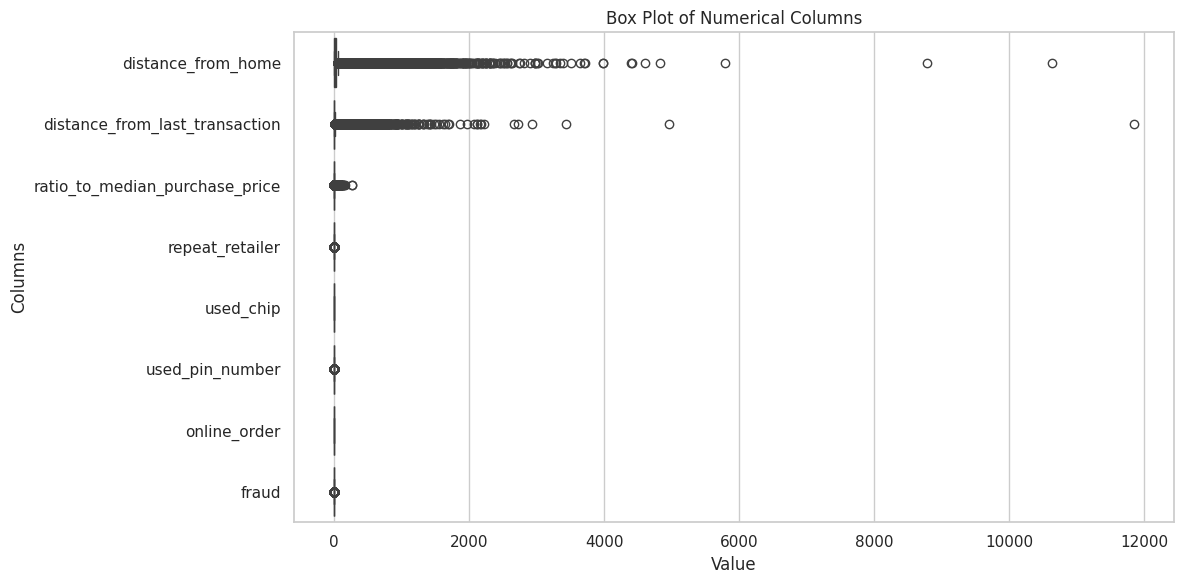

In [10]:
# Create a copy of the original DataFrame
df = df.copy()

# Selecting numerical columns to plot
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Set Seaborn style and color palette
sns.set(style="whitegrid", palette="Blues_r")

# Create a figure with matplotlib
plt.figure(figsize=(12, 6))

# Plotting boxplots for each numerical column
sns.boxplot(data=df[numerical_columns], orient="h")
plt.title('Box Plot of Numerical Columns')
plt.xlabel('Value')
plt.ylabel('Columns')
plt.tight_layout()

# Show plot
plt.show()

In [11]:
def IQR_method(df, n, features):
    outlier_list = []

    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
        # Appending the list of outliers
        outlier_list.extend(outlier_list_column)

    # Selecting observations containing more than n outliers
    outlier_list = Counter(outlier_list)
    multiple_outliers = [k for k, v in outlier_list.items() if v > n ]

    print('Total number of deleted outliers:', len(multiple_outliers))

    return multiple_outliers

# Detecting outliers using the IQR method
Outliers_IQR = IQR_method(df, 1, numerical_columns)

Total number of deleted outliers: 141044


In [12]:
# Dropping outliers from df
df_out = df.drop(Outliers_IQR, axis=0).reset_index(drop=True)

# Print the count of data after removing outliers
print('Total number after deleted outliers:', len(df_out))

Total number after deleted outliers: 858956


In [13]:
# Assuming 'fraud' is your target variable
X = df_out.drop('fraud', axis=1)  # Features (excluding the target 'fraud' column)
y = df_out['fraud']  # Target variable

# Importing train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Performing stratified split with a test size of 30% and a random state of 42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Printing counts of train and test sets
print("Train set:")
print("Total rows:", len(X_train))
print("Frauds:", y_train.sum())
print("Not Frauds:", (y_train == 0).sum())

print("\nTest set:")
print("Total rows:", len(X_test))
print("Frauds:", y_test.sum())
print("Not Frauds:", (y_test == 0).sum())

Train set:
Total rows: 601269
Frauds: 5288.0
Not Frauds: 595981

Test set:
Total rows: 257687
Frauds: 2266.0
Not Frauds: 255421


In [14]:
def Standard_Scaler(df, col_names):
    scaler = StandardScaler()
    df_scaled = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    df_scaled[col_names] = scaler.fit_transform(df_scaled[col_names])

    return df_scaled

# Example usage:
col_names = ['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order']  # List of column names to scale

# Apply StandardScaler to X_train and X_test
X_train_scaled = Standard_Scaler(X_train, col_names)
X_test_scaled = Standard_Scaler(X_test, col_names)

# Print to verify
print("X_train (scaled):")
print(X_train_scaled.head())

print("\nX_test (scaled):")
print(X_test_scaled.head())

X_train (scaled):
        distance_from_home  distance_from_last_transaction  \
634673           -0.406713                       -0.178884   
849056           -0.323700                       -0.062132   
169467            0.097783                        1.227639   
545813           -0.154584                       -0.190525   
642113           -0.242406                       -0.112600   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
634673                       -0.070717        -3.036433  -0.747623   
849056                        0.145639         0.329334   1.337573   
169467                       -0.625640         0.329334  -0.747623   
545813                       -0.467967         0.329334  -0.747623   
642113                        0.562374         0.329334  -0.747623   

        used_pin_number  online_order  
634673        -0.280844      0.768850  
849056        -0.280844     -1.300644  
169467        -0.280844      0.768850  
545813        -0.280844     

In [15]:
oversampler = RandomOverSampler(random_state=42)

# Perform oversampling
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Check the class distribution before and after oversampling
print("Before Up Sampling:", Counter(y_train))
print("After Up Sampling:", Counter(y_train_resampled))

Before Up Sampling: Counter({0.0: 595981, 1.0: 5288})
After Up Sampling: Counter({0.0: 595981, 1.0: 595981})


<ipython-input-16-68552457aee0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='Blues')
<ipython-input-16-68552457aee0>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette='Blues')


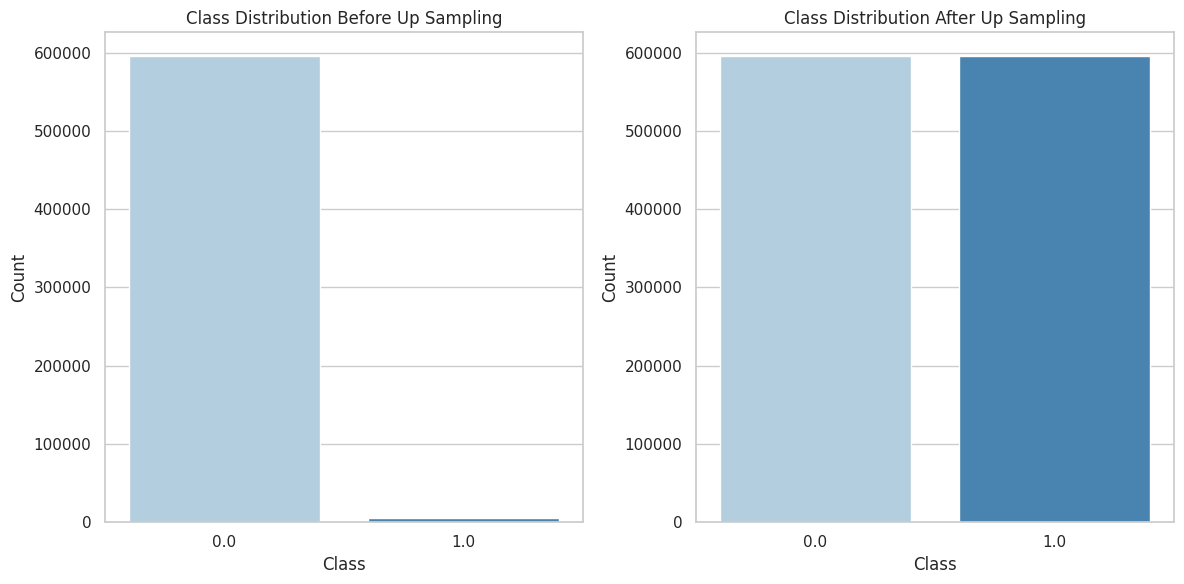

In [16]:
# Calculate class distribution before and after oversampling
before_counts = Counter(y_train)
after_counts = Counter(y_train_resampled)

# Plotting the class distribution
plt.figure(figsize=(12, 6))

# Plot before oversampling
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette='Blues')
plt.title('Class Distribution Before Up Sampling')
plt.xlabel('Class')
plt.ylabel('Count')

# Plot after oversampling
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled, palette='Blues')
plt.title('Class Distribution After Up Sampling')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[251542   3879]
 [     0   2266]]

Precision Score: 0.36875508543531327


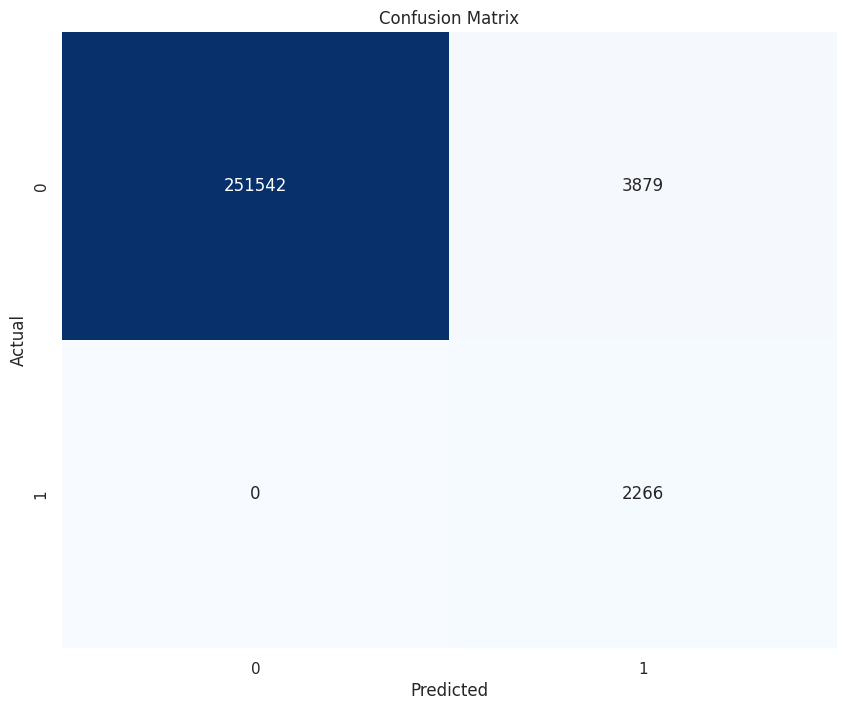


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    255421
         1.0       0.37      1.00      0.54      2266

    accuracy                           0.98    257687
   macro avg       0.68      0.99      0.77    257687
weighted avg       0.99      0.98      0.99    257687



In [22]:
# Import necessary libraries for evaluation
from sklearn.metrics import confusion_matrix, precision_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Import a model - you'll need to decide which one to use
from sklearn.linear_model import LogisticRegression

# Initialize and train your model (replace with your chosen model and parameters)
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled) # Assuming you want to use the resampled data

# Assuming 'model' is your trained model and X_test is your test data
y_pred = model.predict(X_test) # Predict using your trained model

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate precision score
precision = precision_score(y_test, y_pred)
print("\nPrecision Score:", precision)

# Plot confusion matrix with light blue palette
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, classification_report

# Initialize KNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model on oversampled data
knn.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = knn.score(X_test, y_test)
print("\nKNN Accuracy:", accuracy*100)


KNN Accuracy: 99.79548832498341



KNN ROC AUC Score: 0.9871343200915721


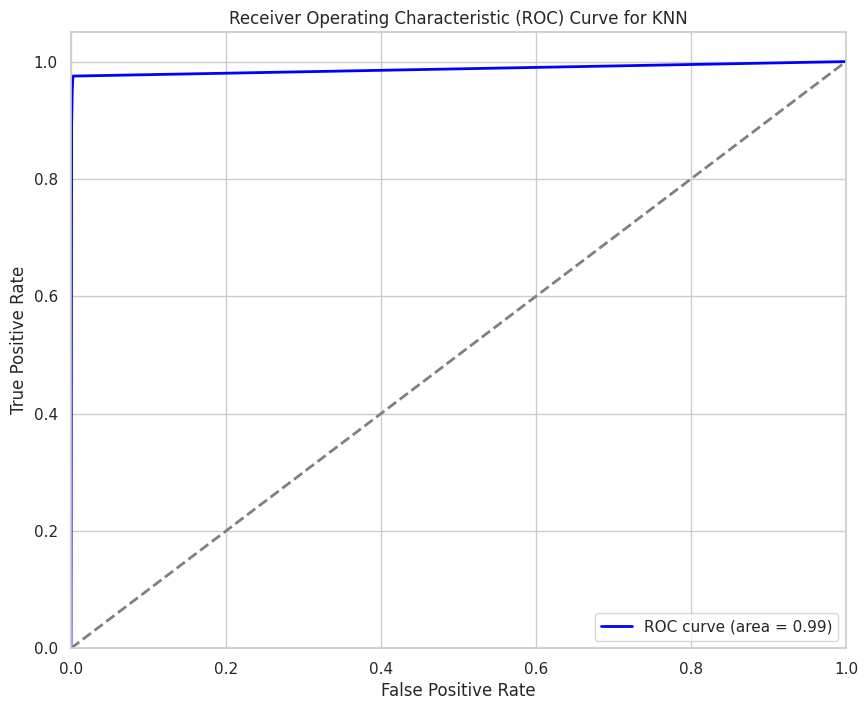

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
# Predict probabilities on test set
y_prob_knn = knn.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_prob_knn)

# Calculate AUC (Area Under Curve)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)
print("\nKNN ROC AUC Score:", roc_auc_knn)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend(loc="lower right")
plt.show()

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Initialize Logistic Regression classifier with increased max_iter and solver
log_reg = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)

# Train the model on scaled oversampled data
log_reg.fit(X_train_scaled, y_train_resampled)

# Predict on test set
y_pred = log_reg.predict(X_test_scaled)

# Calculate accuracy
accuracy = log_reg.score(X_test_scaled, y_test)
print("\nLogistic Regression Accuracy:", accuracy * 100)


Logistic Regression Accuracy: 98.90099228909492


Confusion Matrix:
[[252589   2832]
 [     0   2266]]

Precision Score: 0.4444880345233425


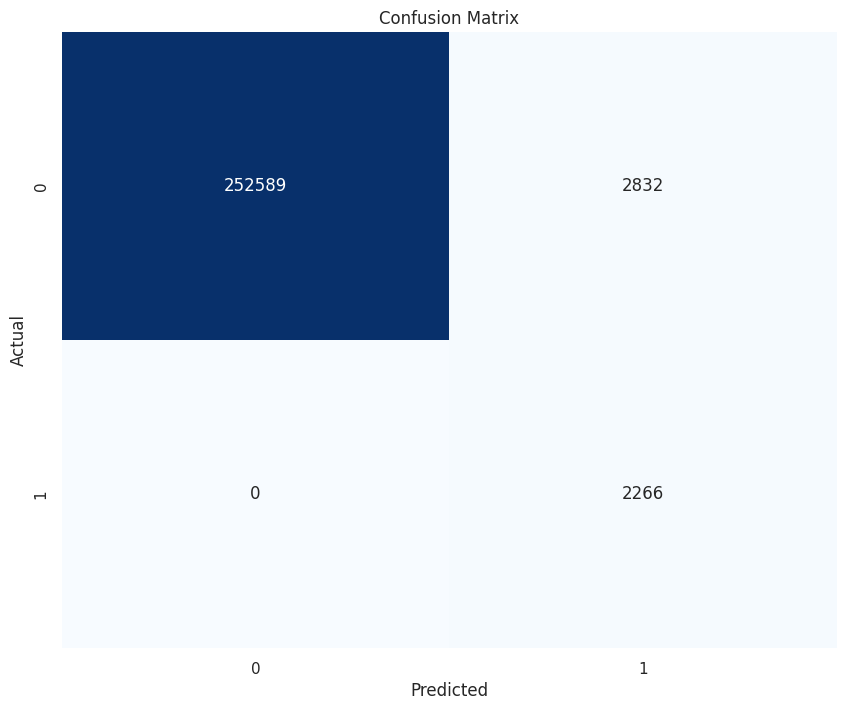


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    255421
         1.0       0.44      1.00      0.62      2266

    accuracy                           0.99    257687
   macro avg       0.72      0.99      0.80    257687
weighted avg       1.00      0.99      0.99    257687



In [26]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate precision score
precision = precision_score(y_test, y_pred)
print("\nPrecision Score:", precision)

# Plot confusion matrix with light blue palette
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression ROC AUC Score: 0.999894382012152


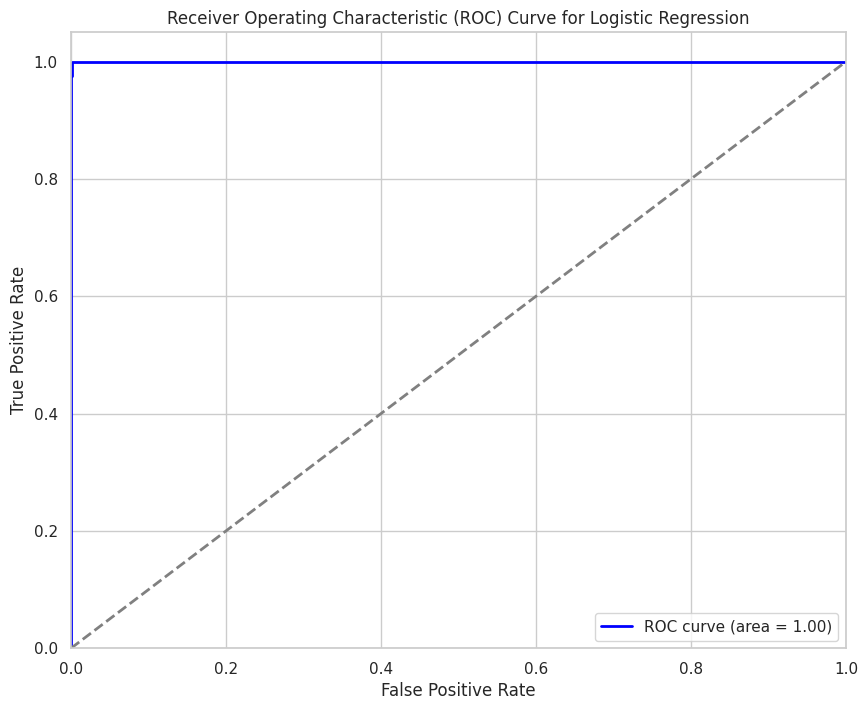

In [27]:

# Predict probabilities on test set
y_prob_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_prob_log_reg)

# Calculate AUC (Area Under Curve)
roc_auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)
print("\nLogistic Regression ROC AUC Score:", roc_auc_log_reg)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_log_reg:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on oversampled data
rf.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = rf.score(X_test, y_test)
print("\nRandom Forest Accuracy:", accuracy*100)


Random Forest Accuracy: 100.0


Confusion Matrix:
[[255421      0]
 [     0   2266]]

Precision Score: 1.0


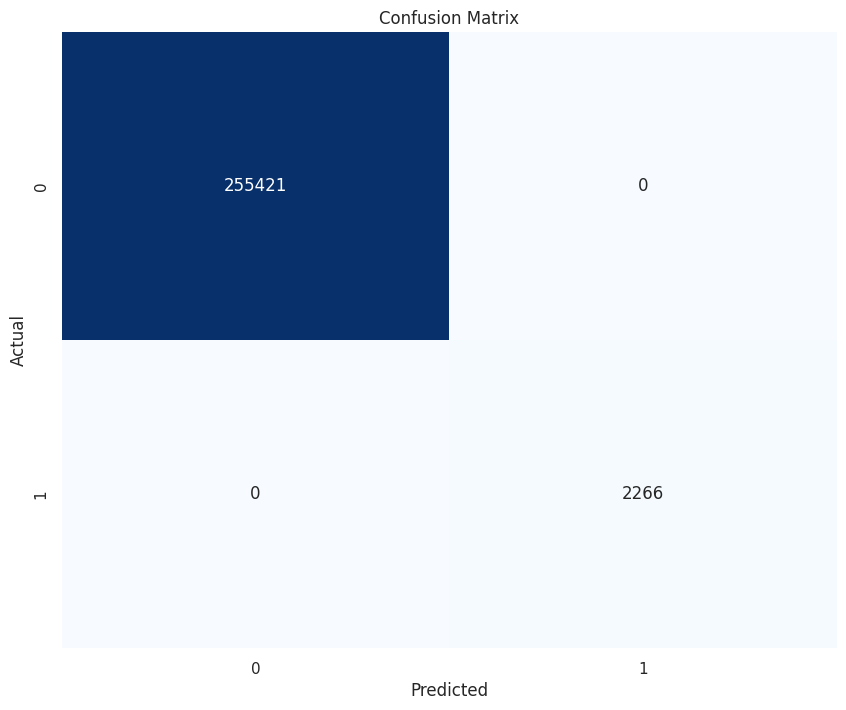


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    255421
         1.0       1.00      1.00      1.00      2266

    accuracy                           1.00    257687
   macro avg       1.00      1.00      1.00    257687
weighted avg       1.00      1.00      1.00    257687



In [29]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate precision score
precision = precision_score(y_test, y_pred)
print("\nPrecision Score:", precision)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Random Forest ROC AUC Score: 1.0


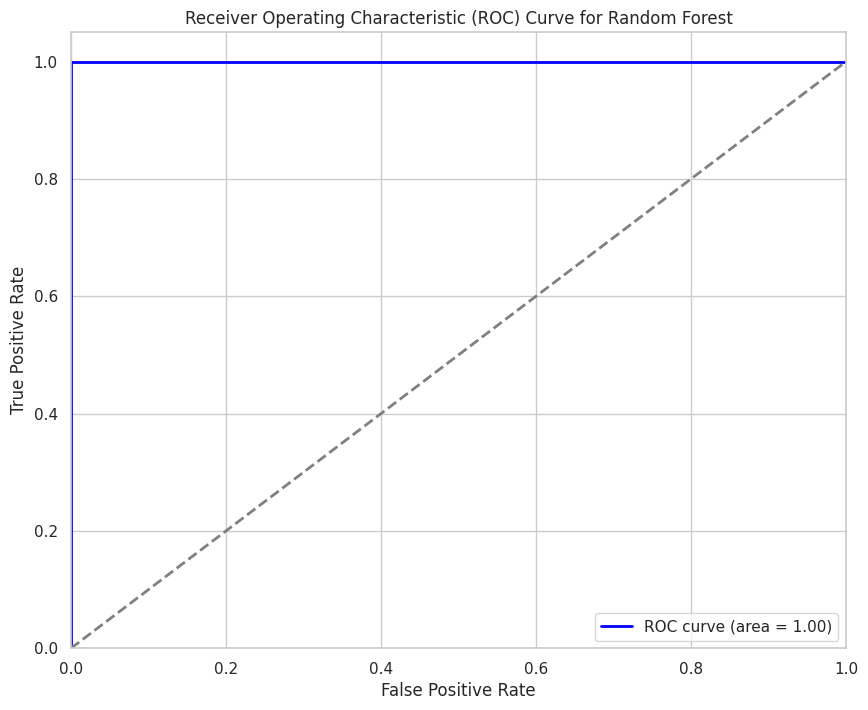

In [30]:
# Predict probabilities for the positive class (fraudulent transactions)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)

# Calculate AUC (Area Under Curve)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print("\nRandom Forest ROC AUC Score:", roc_auc_rf)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

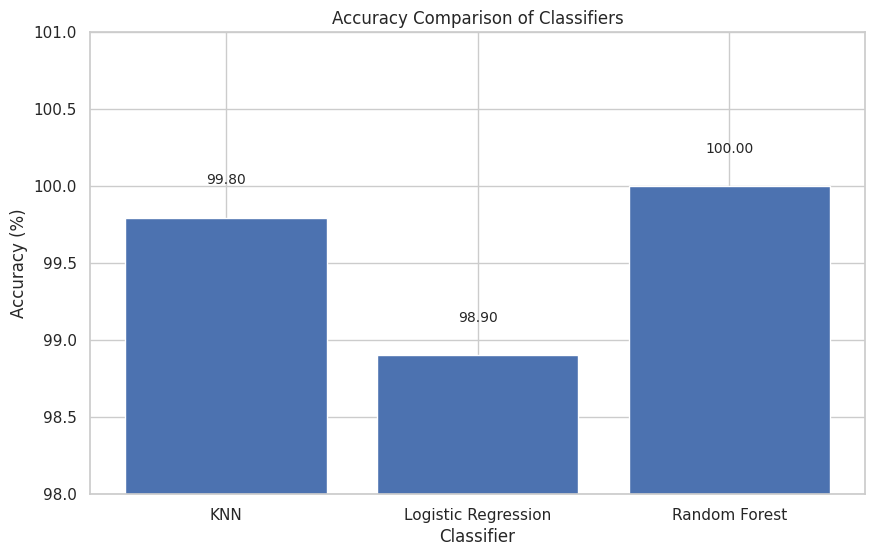

In [31]:
# Define the classifiers and their accuracies
classifiers = ['KNN', 'Logistic Regression', 'Random Forest']
accuracies = [99.79548832498341, 98.90099228909492, 100.0]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color=['#4c72b0', '#4c72b0', '#4c72b0'])

# Adjust ylim to show differences clearly
plt.ylim(98, 101)

plt.title('Accuracy Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Accuracy (%)')

# Displaying the accuracy values on top of the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()